In [1]:
import os
import spotipy
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim
import time 
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

C:\Users\trist\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Create a dataframe to work with and collect genre data from Spotify API so we can reduce it down to labels for the classifier

In [145]:
df = pd.read_csv('C:/Users/trist/OneDrive/Desktop/SpotIpy_Models/All Data/Processed Data/genres_41k.csv')
#remove unnecessary columns

In [146]:
#Create a df to feed into the API to get the genres
df = df.loc[:,['artist',"track","uri",'genres']]
df["uri"].astype('string')
df = df[df['genres']!="[]"]
df = df.reset_index(drop=True)

In [5]:
#  #Sign into Spotify API
# from spotipy.oauth2 import SpotifyClientCredentials

# #Store values for API info
# client_id = your client id
# client_secret = your client secret

In [6]:
#Number of songs pulled at a time
#Utilizing chunk size and time.sleep allowed for less timeouts during the data collection process and reduced the need to keep
#running the script
chunksize = 50

#What song you are starting this run on 
song_index = 0

#Counter for use within the loop
count = 0

#Iterate over the number of songs in the raw dataframe
for n in range(0,len(df),chunksize):
    
    #Instantiate Spotipy object via login
    client_credentials_manager = SpotifyClientCredentials(client_id,client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    #Define the start point for each chunk relative to chunk size and # rounds completed 
    startpoint = song_index + (count * chunksize)

    #Create a dataframe based on the current start point and chunk size
    df_chunk = pd.read_csv('C:/Users/trist/OneDrive/Desktop/SpotIpy_Models/All Data/All_Years_Songs.csv',
                           nrows=chunksize,skiprows=range(1,startpoint),header=0)
    
    #For each item in the chunk
    for x in range(0,len(df_chunk)):

        #Define the attributes of the song
        uri = df_chunk['uri'][x]
        song = sp.track(uri)
        track_artists = song['artists']
        
        #Create a list to store all the genres attributed to the song's artists
        song_genres = []
        
        #Iterate over the artist list and pull their genres in a loop
        for artist in track_artists:
            
            #Get the artist object
            artist_data = sp.artist(artist['id'])
        
            #Add the genres from each artist to the song's raw genre category
            song_genres += artist_data['genres']
        
        #Add the new genre information to the given row in the df
        df_chunk.loc[df_chunk.index[x], 'genres'] = song_genres
        
    #Add one and move onto the next chunk 
    count +=1    
    df_chunk.to_csv("genres.csv",mode='a',header=False,encoding="utf-8")
    time.sleep(5)

In [7]:
#Since the other run stores the data in a csv in the event of a kernel dying or another techincal issue,
#use the csv to redefine df and move into the topic modeling phase

df = pd.read_csv('C:/Users/trist/OneDrive/Desktop/SpotIpy_Models/All Data/Processed Data/genres.csv')

## Once the genre data has been collected from Spotify, use topic modeling to create a few labels that we can run the classifier on 

In [8]:
#Check shape after quick cleaning process
df.head()

,artist,track,uri,genres
0,Montgomery Gentry,Lucky Man,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,"['contemporary country', 'country', 'country r..."
1,Pretty Ricky,On The Hotline,spotify:track:1zyqZONW985Cs4osz9wlsu,"['dance pop', 'hip hop', 'hip pop', 'miami hip..."
2,Candlemass,Clouds Of Dementia,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,"['death metal', 'doom metal', 'epic doom', 'ha..."
3,Zwartketterij,"Heavy Metal, Raise Hell!",spotify:track:2IjBPp2vMeX7LggzRN3iSX,['dutch black metal']
4,Billy Currington,I Got A Feelin',spotify:track:1tF370eYXUcWwkIvaq3IGz,"['contemporary country', 'country', 'country r..."


Begin the cleaning process for the genres; at the end, you should convert the string (which becomes a list) of genres to one "outcome"

Begin the lyric cleaning process; strip the lyrics of brackets and then process line breaks.

In [9]:
df['genres'].head()

0    ['contemporary country', 'country', 'country r...
1    ['dance pop', 'hip hop', 'hip pop', 'miami hip...
2    ['death metal', 'doom metal', 'epic doom', 'ha...
3                                ['dutch black metal']
4    ['contemporary country', 'country', 'country r...
Name: genres, dtype: object

In [147]:
#Use LDA topic model to figure out the number of "genres" present in our dataset
tokenized_genres=[]
for row in df['genres']:
    
        
    #Cut out punctuation
    row = re.sub(r'[^\w\s]','',row)
    
    #Convert hip hop to hiphop since those words would be split in tokenization otherwise    
    row = re.sub(r'hip hop', 'hiphop',row)
        
    #Convert all upper-case words to lower-case
    row = row.lower()
    
    #Tokenize the genres
    row = nltk.word_tokenize(row)
        
    #Stem the words    
    row = [PorterStemmer().stem(item) for item in row]
    
    #Append to the list
    tokenized_genres.append(row)

#Add column with our tokens for LDA
df['tokenized_genres'] = tokenized_genres

In [11]:
#Visualize what tokenized genres and the rest of our DF looks like
df.head()

,artist,track,uri,genres,tokenized_genres
0,Montgomery Gentry,Lucky Man,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,"['contemporary country', 'country', 'country r...","[contemporari, countri, countri, countri, road..."
1,Pretty Ricky,On The Hotline,spotify:track:1zyqZONW985Cs4osz9wlsu,"['dance pop', 'hip hop', 'hip pop', 'miami hip...","[danc, pop, hiphop, hip, pop, miami, hiphop, p..."
2,Candlemass,Clouds Of Dementia,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,"['death metal', 'doom metal', 'epic doom', 'ha...","[death, metal, doom, metal, epic, doom, hard, ..."
3,Zwartketterij,"Heavy Metal, Raise Hell!",spotify:track:2IjBPp2vMeX7LggzRN3iSX,['dutch black metal'],"[dutch, black, metal]"
4,Billy Currington,I Got A Feelin',spotify:track:1tF370eYXUcWwkIvaq3IGz,"['contemporary country', 'country', 'country r...","[contemporari, countri, countri, countri, road]"


In [12]:
#Built dict for LDA and determine appropriate number of genres
genre_dict = Dictionary(df['tokenized_genres'])

#Create corpus with word occurances
genre_corpus = [genre_dict.doc2bow(row) for row in df['tokenized_genres']]

In [85]:
#Create list to track our coherences as n grows 
coherence_list = []

#for potential n topics in a range, run a LDA and Coherence Model to determine appropriate alpha/eta to account for sparsity 
for topic_count in range(1,25):
    #Minimize eta and alpha to reduce long tail on topics, which should help define genres more cleanly
    lda_model = LdaMulticore(genre_corpus, num_topics = topic_count, id2word = genre_dict, 
                             chunksize=10000, passes=25,random_state=42,iterations=15,workers=7,
                            minimum_probability=0.0,eta=.0000001,alpha=.0000001)
    
    #Define the coherence model to visualize each version of lda in the loop with the number of topics
    coherence_model = CoherenceModel(model=lda_model,corpus=genre_corpus,dictionary=genre_dict,coherence='u_mass')
    
    #Get the model's coherence score (the lower the number the better given the u-mass metric)
    coherence = coherence_model.get_coherence()
    
    #Add the coherence to the list
    coherence_list.append(coherence)

[-4.182235924395031, -5.886848897802817, -7.081036612930792, -6.039945273125813, -5.626952420683326, -6.448211060854903, -6.8107419504535125, -7.189246099296099, -6.8557313627881, -6.801947725812444, -6.852326613345467, -6.441141410047133, -7.574376226803053, -6.6102185145088965, -7.237089326716254, -6.5629441372258945, -6.7209067997914715, -6.816075855734052, -7.3759659594221185, -7.133970702490158, -6.9984923847320655, -7.441700430000815, -7.717026276645205, -7.700422798127977]


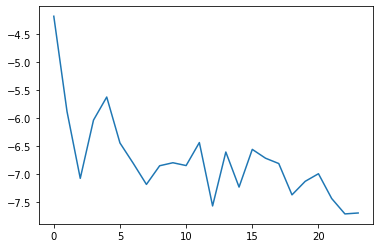

In [86]:
#Plot the coherence list as a quick line chart
plt.plot(coherence_list)
plt.show()

In [113]:
#Create a tuned model that runs off a reasonable # topics
#This was originally automated to be the min of the chart above, but changed because that wouldn't be granular enough
tuned_lda = LdaMulticore(genre_corpus, num_topics = 23, 
                         id2word = genre_dict, chunksize=10000, passes=25,
                         random_state=42,iterations=15, workers=7, minimum_probability=0.0,eta=.0000001,alpha=.0000001)

In [114]:
#Check out the contents of each topic based on the determined number of topics
tuned_lda.show_topics(num_topics=23)

[(0,
  '0.151*"rock" + 0.108*"folk" + 0.099*"experiment" + 0.051*"industri" + 0.039*"art" + 0.025*"american" + 0.024*"psychedel" + 0.018*"british" + 0.018*"dark" + 0.018*"outsid"'),
 (1,
  '0.250*"punk" + 0.073*"hardcor" + 0.044*"emo" + 0.035*"rock" + 0.027*"pub" + 0.025*"flamenco" + 0.024*"theme" + 0.020*"ska" + 0.019*"posthardcor" + 0.015*"screamo"'),
 (2,
  '0.269*"rap" + 0.232*"hiphop" + 0.081*"pop" + 0.057*"trap" + 0.043*"southern" + 0.037*"gangster" + 0.023*"coast" + 0.021*"atl" + 0.020*"south" + 0.017*"dirti"'),
 (3,
  '0.299*"soul" + 0.091*"funk" + 0.088*"motown" + 0.073*"classic" + 0.071*"quiet" + 0.071*"storm" + 0.047*"southern" + 0.046*"disco" + 0.027*"blue" + 0.020*"postdisco"'),
 (4,
  '0.210*"pop" + 0.094*"build" + 0.094*"brill" + 0.072*"bubblegum" + 0.070*"rockandrol" + 0.053*"folk" + 0.048*"rock" + 0.044*"rockabilli" + 0.039*"classic" + 0.034*"adult"'),
 (5,
  '0.122*"latin" + 0.074*"music" + 0.068*"black" + 0.061*"librari" + 0.047*"spytrack" + 0.034*"spanish" + 0.034*"

In [129]:
#Define a list of categories to refilter based on a glance at the above output
refilter_list = [6,7,9,14,17,21]

In [148]:
from operator import itemgetter
category_labels = []

#Use len instead of df['tokenized_genres'] to use numerical indexing instead of using an index function
for row in range(0,len(df)):
    
    #Define the probabilities of belonging to a category
    distr = tuned_lda[genre_corpus[row]]
    cat_label=(max(distr,key=itemgetter(1)))[0]
    #See if we can refilter the categories for songs that landed on cut categories
    try:
        #If the label is on the cut list, refilter it
        if cat_label in refilter_list:
            #Create a variable for the second most prevalent category
            secondary_tuple = sorted(distr,key=itemgetter(1))[-2]
            #Account for the fact that it could be a very low number and filter out anythng under 1%
            if secondary_tuple[1]<.01:
                cat_label = "CUT"
    #If there is only one result in the output (which occured during testing), create a case that will cut the song since 
    #it cannot get an assignment from elsewhere
    except IndexError:
        cat_label="CUT"
        
    #Add the label to the list once it is sorted out
    category_labels.append(cat_label)

In [149]:
#Check our outputs and the distribution of the categories
df['cat_numbers'] = category_labels

df['cat_numbers'].value_counts()

CUT    6806
18     4816
3      3501
4      2941
8      2891
2      2256
15     2221
10     2162
20     2077
19     1981
0      1823
6      1611
1      1546
12     1535
13     1533
22     1506
5      1399
14      942
16      821
9       770
11      672
7       543
21      533
17      333
Name: cat_numbers, dtype: int64

In [156]:
#Define a list of numbers and actual labels to convert into the final product for the predictive model
replacement_tuples = [(12,'EDM'),([16,19],'Jazz'),(2,'Rap'),([3,13],'R&B'),([5,22],'Latin'),([4,10],'Pop'),
                  ([11,15],'Country'),([0,1,18,20,8],'Rock')]

#For each pair of labels and categories, change the number in the df to the label itself
for pair in replacement_tuples:
    
    df['cat_numbers'].replace(replacement_tuples[0],replacement_tuples[1],inplace=True)


#Filter out the cut list when done
df['cat_numbers'].replace(refilter_list, "CUT",inplace=True)

df.head()

,artist,track,cat_numbers
0,Montgomery Gentry,Lucky Man,Country
1,Pretty Ricky,On The Hotline,Rap
2,Candlemass,Clouds Of Dementia,Rock
3,Zwartketterij,"Heavy Metal, Raise Hell!",Rock
4,Billy Currington,I Got A Feelin',Country


In [151]:
#Since coefficients on #13 were extremely small above, drop the two songs that got put here by the LDA model
df = df[df['cat_numbers'] != "CUT"]

In [152]:
#As we can see, the genre method at hand right now does not quite word as presented given the long tail of genres and non-genre results
df['cat_numbers'].value_counts()

Rock       13153
Pop         5103
R&B         5034
Latin       2905
Country     2893
Jazz        2802
Rap         2256
EDM         1535
Name: cat_numbers, dtype: int64

In [153]:
#Check out our dataframe after genre conversion
df = df.loc[:,['artist','track','cat_numbers']]
df.head()

,artist,track,cat_numbers
0,Montgomery Gentry,Lucky Man,Country
1,Pretty Ricky,On The Hotline,Rap
2,Candlemass,Clouds Of Dementia,Rock
3,Zwartketterij,"Heavy Metal, Raise Hell!",Rock
4,Billy Currington,I Got A Feelin',Country


In [154]:
#Upload Topic Model Outputs to Flat Files for use in classifier
df.to_csv("Labelled_Data.csv",index=True)

#This is not a perfect process and further iteration on the genres themselves could be done by changing the input data. 
#The purpose of this workbook/process now is to create a MVP of the web app. Further iteration could change some processes. 